## Imports.

In [1]:
## Imports.
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

sns.set() #set Seaborn theme on plots.

from datetime import date

## Constants & Directories.

In [92]:
## Models.

# BabyBERTa.
# The authors made 3/10 random initializations of the model publicly available.
MODELS = ['phueb/BabyBERTa-1', 
          'phueb/BabyBERTa-2', 
          'phueb/BabyBERTa-3', 
          'bert-base-cased', 
          'bert-large-cased', 
          'roberta-base',
          'roberta-large',
        ] 
SAVED_MODELS = ['saved_models/BabyBERTa_AO-CHILDES',
                'saved_models/BabyBERTa_AO-CHILDES_standard_masking',
                'saved_models/BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1',
                'saved_models/BabyBERTa_AO-Newsela',
                'saved_models/BabyBERTa_Wikipedia-1',
               ]

## Original Data.
BLIMP_ORIGINAL = "./output/BLiMP/blimp_original.csv"
ZORRO_ORIGINAL = "./output/Zorro/zorro_original.csv"

# CHILDES.
CHILDES = './data/CHILDES/aochildes.txt'

# BLiMP.
BLIMP = './data/BLiMP/' # data across many files.

# Zorro.
ZORRO = './data/Zorro/'
ZORRO_SCRAMBLED = './data/Zorro_scrambled/'

## Output Directories.
BABYBERTA_SCRAMBLED_ZORRO_OUT = './output/Zorro_scrambled/babyberta_zorro_scrambled_mlm.csv'

ALL_MODELS_BLIMP_OUT = './output/BLiMP/all_models_blimp_mlm.csv'
ALL_MODELS_ZORRO_OUT = './output/Zorro/all_models_zorro_mlm.csv'

## Helper Functions

In [24]:
def results_by_phenomenon(output_df, model_col="model", phenomenon_col="linguistics_term", paradigm_col=None, correct_col="correct"):
    # Create new dataframe.
    if paradigm_col == None:
        columns = output_df[phenomenon_col].unique()
    else:
        columns = pd.MultiIndex.from_frame(output_df[[phenomenon_col, paradigm_col]])
        
    results = pd.DataFrame(index=output_df[model_col].unique(), columns=columns)
    
    for idx, row in results.iterrows():
        subset = output_df.loc[output_df[model_col] == idx]
        if paradigm_col == None:
            for phenomenon in row.index:
                row[phenomenon] = subset[correct_col].loc[subset[phenomenon_col] == phenomenon].mean()
        else:
            for phenomenon, paradigm in row.index:
                row[phenomenon, paradigm] = subset[correct_col].loc[(subset[phenomenon_col] == phenomenon) &
                                                                    (subset[paradigm_col] == paradigm)].mean()
    return results

In [75]:
def results_by_paradigm(output_df, model_col="model", phenomenon_col="phenomenon", paradigm_col="paradigm", correct_col="correct"):
    # Create new dataframe for DataFrame.groupby().    
    new_cols = [model_col, phenomenon_col, paradigm_col, correct_col]
    results = output_df[new_cols]

    # Apply DataFrame.groupby() averaging over the correct_col.
    results = results.groupby(new_cols[:-1]).mean().reset_index()
    
    return results

## Load the data.

In [93]:
# Results by our experimentation.
all_models_blimp = pd.read_csv(ALL_MODELS_BLIMP_OUT)
all_models_zorro = pd.read_csv(ALL_MODELS_ZORRO_OUT)

# Results by original BabyBERTa authors.
original_blimp_results = pd.read_csv(BLIMP_ORIGINAL)
original_zorro_results = pd.read_csv(ZORRO_ORIGINAL)

# Results on Scrambled Zorro.
scrambled_zorro_results = pd.read_csv(BABYBERTA_SCRAMBLED_ZORRO_OUT)

/tmp/ipykernel_3187/3276363085.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_models_blimp = pd.read_csv(ALL_MODELS_BLIMP_OUT)


In [95]:
# Add a column for correctly scored minimal pairs.
all_models_blimp["correct"] = (all_models_blimp.pseudoLogProb_good > all_models_blimp.pseudoLogProb_bad).astype(int)
all_models_zorro["correct"] = (all_models_zorro.pseudoLogProb_good > all_models_zorro.pseudoLogProb_bad).astype(int)
scrambled_zorro_results["correct"] = (scrambled_zorro_results.pseudoLogProb_good > scrambled_zorro_results.pseudoLogProb_bad).astype(int)

## Plot the results my model and phenomenon.

In [28]:
## Tabulate the raw data by phenomenon.
blimp_phen_results = results_by_phenomenon(all_models_blimp,
                                           model_col="model",
                                           phenomenon_col="linguistics_term",
                                           correct_col="correct",
                                          )
zorro_phen_results = results_by_phenomenon(all_models_zorro,
                                           model_col="model",
                                           phenomenon_col="phenomenon",
                                           correct_col="correct",
                                          )

In [31]:
## Reorder the columns for the visualization.
ordered_blimp_phenomena = ["anaphor_agreement", "argument_structure", "binding", "control_raising", "determiner_noun_agreement", "ellipsis", "filler_gap_dependency", "irregular_forms", "island_effects", "npi_licensing", "quantifiers", "subject_verb_agreement"]
ordered_zorro_phenomena = ["anaphor_agreement", "argument_structure", "binding", "case", "agreement_determiner_noun", "ellipsis", "filler-gap", "irregular", "island-effects", "local_attractor", "npi_licensing", "quantifiers", "agreement_subject_verb"]

blimp_phen_results = blimp_phen_results[ordered_blimp_phenomena]
zorro_phen_results = zorro_phen_results[ordered_zorro_phenomena]

In [33]:
## Print perfomrance of each model on both datasets.
for model in all_models_blimp.model.unique():
    subset_blimp = all_models_blimp.loc[all_models_blimp.model == model]
    subset_zorro = all_models_zorro.loc[all_models_zorro.model == model]

    print(f"Overall {model} performance on:\n" +\
          f"\t -BLIMP: {subset_blimp.correct.sum()}/{subset_blimp.size} ({np.mean(subset_blimp.correct)})\n" +\
          f"\t -Zorro: {subset_zorro.correct.sum()}/{subset_zorro.size} ({np.mean(subset_zorro.correct)}) \n")

Overall BabyBERTa_AO-CHILDES performance on:
	 -BLIMP: 40685/1608000 (0.6072388059701492)
	 -Zorro: 36298/460000 (0.7890869565217391) 

Overall BabyBERTa_AO-CHILDES_standard_masking performance on:
	 -BLIMP: 40473/1608000 (0.6040746268656716)
	 -Zorro: 36528/460000 (0.7940869565217391) 

Overall BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1 performance on:
	 -BLIMP: 45449/1608000 (0.6783432835820895)
	 -Zorro: 39348/460000 (0.8553913043478261) 

Overall BabyBERTa_AO-Newsela performance on:
	 -BLIMP: 42896/1608000 (0.6402388059701493)
	 -Zorro: 36120/460000 (0.7852173913043479) 

Overall BabyBERTa_Wikipedia-1 performance on:
	 -BLIMP: 42192/1608000 (0.629731343283582)
	 -Zorro: 34693/460000 (0.754195652173913) 

Overall BabyBERTa-1 performance on:
	 -BLIMP: 40685/1608000 (0.6072388059701492)
	 -Zorro: 36298/460000 (0.7890869565217391) 

Overall BabyBERTa-2 performance on:
	 -BLIMP: 40902/1608000 (0.6104776119402985)
	 -Zorro: 35991/460000 (0.7824130434782609) 

Overall BabyBERTa-3 perfor

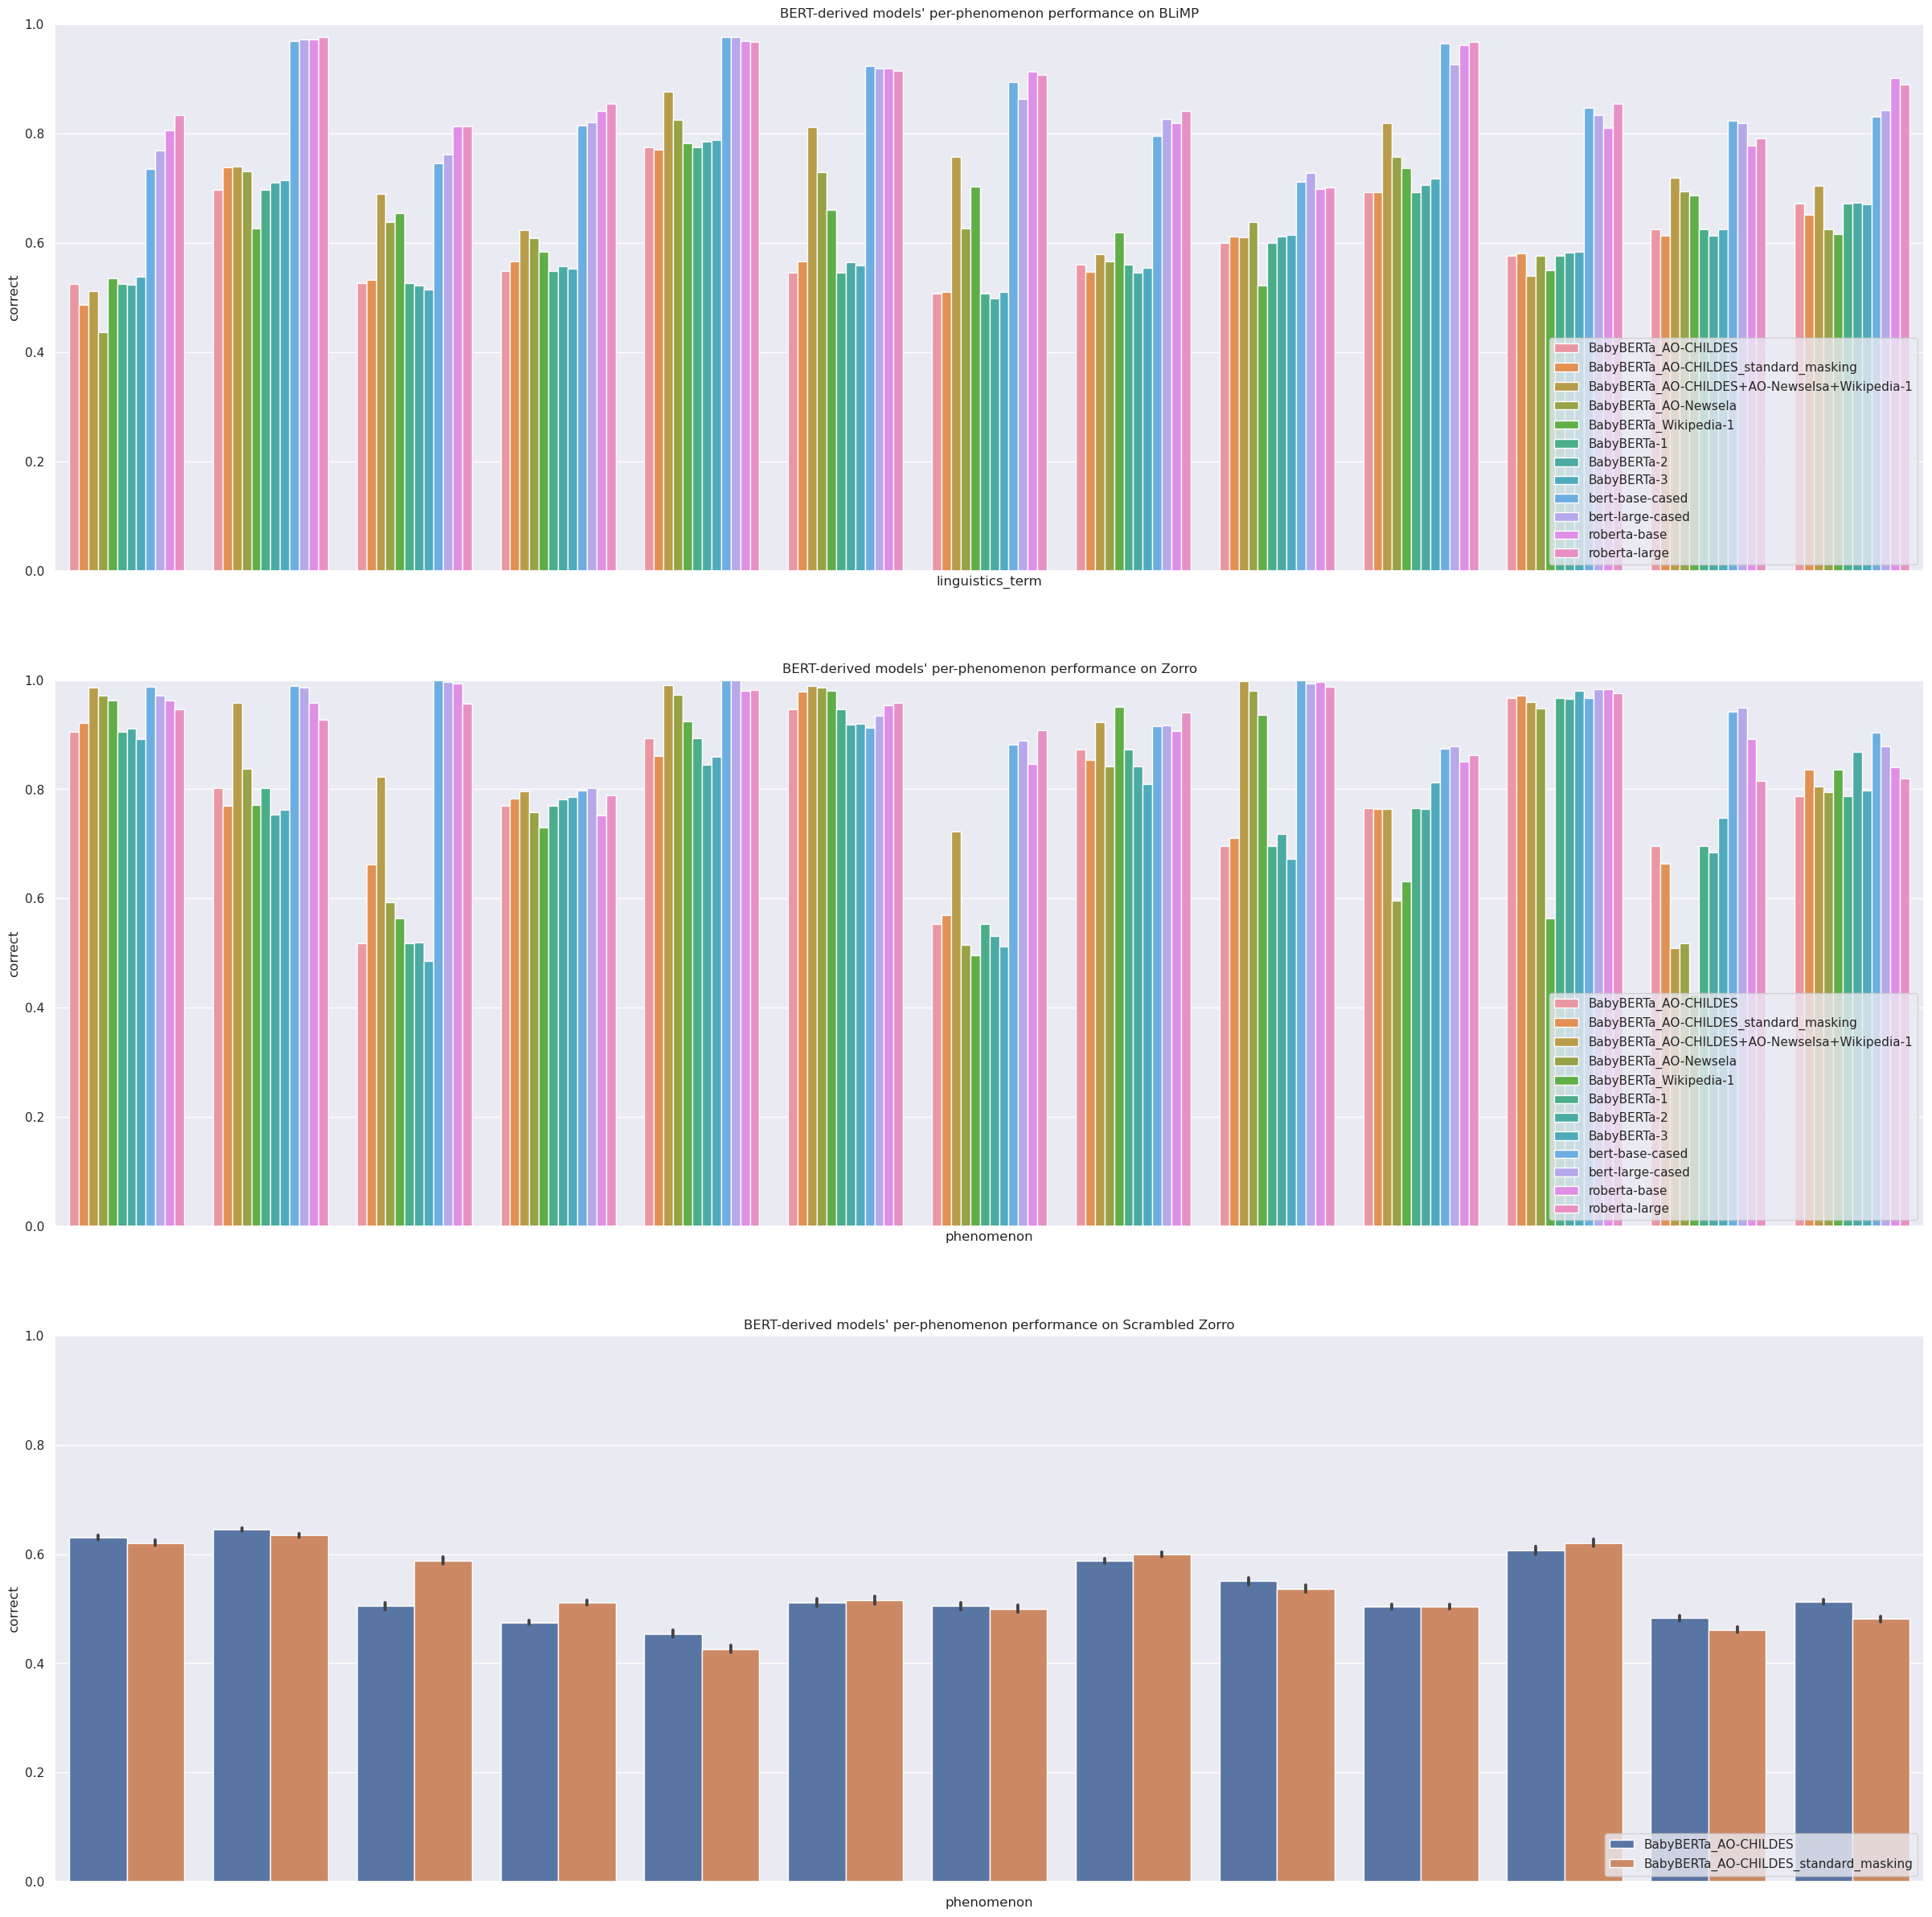

In [115]:
# Plot.
fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(30, 30))
sns.barplot(all_models_blimp, x="linguistics_term", y="correct", hue="model", errorbar=None, ax=axes[0])
sns.barplot(all_models_zorro, x="phenomenon", y="correct", hue="model", errorbar=None, ax=axes[1])
sns.barplot(scrambled_zorro_results, x="phenomenon", y="correct", hue="model", errorbar="ci", ax=axes[2])

#ax.bar_label(ax.containers[-1], fmt='Mean:\n%.2f', label_type='edge') # Label the bars.
# Include overall average performance.
#ax.axhline(y=babyberta_blimp_avg_perf, label='BabyBERTA-1 mean BLiMP perf.', linestyle='--');

# Styling and labeling.
for ax in axes:
    ax.set_ylim([0.0, 1.0])
    ax.legend(loc="lower right");
    
    #print(ax.get_xticks())
    ax.set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    
axes[0].set_title("BERT-derived models' per-phenomenon performance on BLiMP")
axes[1].set_title("BERT-derived models' per-phenomenon performance on Zorro")
axes[2].set_title("BERT-derived models' per-phenomenon performance on Scrambled Zorro")

#plt.xticks(axes[0].get_xticks(), labels=axes[1].get_xticklabels(), rotation=45, ha='right');

plt.show()

In [60]:
display(blimp_phen_results)

,anaphor_agreement,argument_structure,binding,control_raising,determiner_noun_agreement,ellipsis,filler_gap_dependency,irregular_forms,island_effects,npi_licensing,quantifiers,subject_verb_agreement
BabyBERTa_AO-CHILDES,0.6965,0.548571,0.625429,0.56,0.77525,0.5075,0.672286,0.693,0.525625,0.575857,0.60025,0.546
BabyBERTa_AO-CHILDES_standard_masking,0.738,0.565714,0.612714,0.5474,0.771375,0.5105,0.651143,0.6925,0.487375,0.581,0.612,0.566167
BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1,0.74,0.623714,0.718857,0.5788,0.877,0.758,0.704286,0.82,0.512375,0.540143,0.61,0.812667
BabyBERTa_AO-Newsela,0.7305,0.608429,0.694429,0.5662,0.82475,0.626,0.624571,0.757,0.437375,0.576857,0.63825,0.730167
BabyBERTa_Wikipedia-1,0.6265,0.584429,0.687143,0.6196,0.7825,0.7035,0.616429,0.737,0.534625,0.550286,0.522,0.659667
BabyBERTa-1,0.6965,0.548571,0.625429,0.56,0.77525,0.5075,0.672286,0.693,0.525625,0.575857,0.60025,0.546
BabyBERTa-2,0.7105,0.557286,0.613714,0.5462,0.7855,0.4985,0.673571,0.7055,0.52375,0.582429,0.6125,0.564333
BabyBERTa-3,0.715,0.553,0.624857,0.554,0.78875,0.5105,0.670714,0.7175,0.53825,0.584286,0.61525,0.558167
bert-base-cased,0.9695,0.815571,0.823286,0.7956,0.97625,0.894,0.830714,0.965,0.73575,0.846571,0.71225,0.924
bert-large-cased,0.972,0.820286,0.82,0.827,0.976375,0.864,0.842857,0.9275,0.77,0.834,0.72825,0.919167


In [61]:
display(zorro_phen_results)

,anaphor_agreement,argument_structure,binding,case,agreement_determiner_noun,ellipsis,filler-gap,irregular,island-effects,local_attractor,npi_licensing,quantifiers,agreement_subject_verb
BabyBERTa_AO-CHILDES,0.5175,0.769833,0.894,0.947,0.90575,0.553,0.87225,0.6965,0.766,0.9665,0.69675,0.78725,0.80225
BabyBERTa_AO-CHILDES_standard_masking,0.663,0.783667,0.8605,0.978,0.9215,0.5695,0.854,0.7115,0.7645,0.972,0.6635,0.83575,0.77
BabyBERTa_AO-CHILDES+AO-Newselsa+Wikipedia-1,0.822,0.795667,0.991,0.9895,0.9855,0.722,0.923,0.9975,0.764,0.9595,0.50875,0.8045,0.9585
BabyBERTa_AO-Newsela,0.593,0.7575,0.973,0.9865,0.97075,0.5145,0.84125,0.9805,0.5965,0.9475,0.51875,0.79525,0.836875
BabyBERTa_Wikipedia-1,0.564,0.730333,0.924,0.9795,0.963,0.4955,0.951,0.9355,0.631,0.564,0.424,0.8365,0.7705
BabyBERTa-1,0.5175,0.769833,0.894,0.947,0.90575,0.553,0.87225,0.6965,0.766,0.9665,0.69675,0.78725,0.80225
BabyBERTa-2,0.5195,0.782,0.8455,0.9185,0.91175,0.531,0.84225,0.7175,0.7635,0.965,0.68375,0.868,0.7535
BabyBERTa-3,0.485,0.785333,0.86,0.9195,0.89225,0.512,0.8095,0.672,0.812,0.9805,0.74725,0.79725,0.763
bert-base-cased,1.0,0.798333,0.9995,0.913,0.987,0.881,0.916,1.0,0.8735,0.9665,0.94175,0.90375,0.989375
bert-large-cased,0.997,0.802833,0.9995,0.934,0.9715,0.8885,0.917,0.994,0.87875,0.983,0.9495,0.87925,0.985375


## Print the results my model, phenomenon, and paradigm.

In [76]:
blimp_paradigm_results = results_by_paradigm(all_models_blimp,
                                             model_col="model",
                                             phenomenon_col="linguistics_term",
                                             paradigm_col="UID",
                                             correct_col="correct",
                                            )
zorro_paradigm_results = results_by_paradigm(all_models_zorro,
                                             model_col="model",
                                             phenomenon_col="phenomenon",
                                             paradigm_col="paradigm",
                                             correct_col="correct",
                                            )

In [77]:
display(blimp_paradigm_results)

,model,linguistics_term,UID,correct
0,BabyBERTa-1,anaphor_agreement,anaphor_gender_agreement,0.656
1,BabyBERTa-1,anaphor_agreement,anaphor_number_agreement,0.737
2,BabyBERTa-1,argument_structure,causative,0.585
3,BabyBERTa-1,argument_structure,drop_argument,0.632
4,BabyBERTa-1,argument_structure,inchoative,0.507
...,...,...,...,...
799,roberta-large,subject_verb_agreement,distractor_agreement_relative_clause,0.824
800,roberta-large,subject_verb_agreement,irregular_plural_subject_verb_agreement_1,0.916
801,roberta-large,subject_verb_agreement,irregular_plural_subject_verb_agreement_2,0.884
802,roberta-large,subject_verb_agreement,regular_plural_subject_verb_agreement_1,0.959


In [89]:
blimp_paradigm_results.to_csv("./output/BLiMP/blimp_perf_by_paradigm.csv", index=False)

In [79]:
display(zorro_paradigm_results)

,model,phenomenon,paradigm,correct
0,BabyBERTa-1,agreement_determiner_noun,across_1_adjective,0.8985
1,BabyBERTa-1,agreement_determiner_noun,between_neighbors,0.9130
2,BabyBERTa-1,agreement_subject_verb,across_prepositional_phrase,0.7285
3,BabyBERTa-1,agreement_subject_verb,across_relative_clause,0.6485
4,BabyBERTa-1,agreement_subject_verb,in_question_with_aux,0.9085
...,...,...,...,...
271,roberta-large,local_attractor,in_question_with_aux,0.9765
272,roberta-large,npi_licensing,matrix_question,0.6385
273,roberta-large,npi_licensing,only_npi_licensor,0.9915
274,roberta-large,quantifiers,existential_there,0.9170


In [90]:
zorro_paradigm_results.to_csv("./output/Zorro/zorro_perf_by_paradigm.csv", index=False)

## Compare the results to the BabyBERTa authors' results.

## Experiment with Scrambled Zorro.

In [97]:
scrambled_zorro_results

,sentence_good,sentence_bad,phenomenon,paradigm,scrambling_seed,model,orig_min_pair_idx,date,pseudoLogProb_good,pseudoLogProb_bad,correct
0,thing this at look . purple,things this at look . purple,agreement_determiner_noun,across_1_adjective,0,BabyBERTa_AO-CHILDES,0,2023-04-04,-58.848204,-61.045621,1
1,there this purple . thing went,there this purple . things went,agreement_determiner_noun,across_1_adjective,0,BabyBERTa_AO-CHILDES,1,2023-04-04,-53.739722,-64.322536,1
2,. did this happen thing purple not,. did this happen things purple not,agreement_determiner_noun,across_1_adjective,0,BabyBERTa_AO-CHILDES,2,2023-04-04,-72.952299,-70.202451,0
3,this i purple saw . thing,this i purple saw . things,agreement_determiner_noun,across_1_adjective,0,BabyBERTa_AO-CHILDES,3,2023-04-04,-65.346006,-66.138787,1
4,purple thing at that look .,purple things at that look .,agreement_determiner_noun,across_1_adjective,0,BabyBERTa_AO-CHILDES,4,2023-04-04,-29.487081,-32.578363,1
...,...,...,...,...,...,...,...,...,...,...,...
919995,more could carry one . parent than sister no,at could carry one . parent least sister no,quantifiers,superlative,9,BabyBERTa_AO-CHILDES_standard_masking,45995,2023-04-04,-87.701328,-96.936533,1
919996,of more no thirty slave . the could size toys ...,of at no thirty slave . the could size toys le...,quantifiers,superlative,9,BabyBERTa_AO-CHILDES_standard_masking,45996,2023-04-04,-123.349215,-123.474147,1
919997,king than one no boat catch could . fewer,king most one no boat catch could . at,quantifiers,superlative,9,BabyBERTa_AO-CHILDES_standard_masking,45997,2023-04-04,-86.782664,-89.646802,1
919998,doctor more . can girls no than move thirty to,doctor at . can girls no least move thirty to,quantifiers,superlative,9,BabyBERTa_AO-CHILDES_standard_masking,45998,2023-04-04,-99.651133,-105.955838,1


/home/hjvm/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/hjvm/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


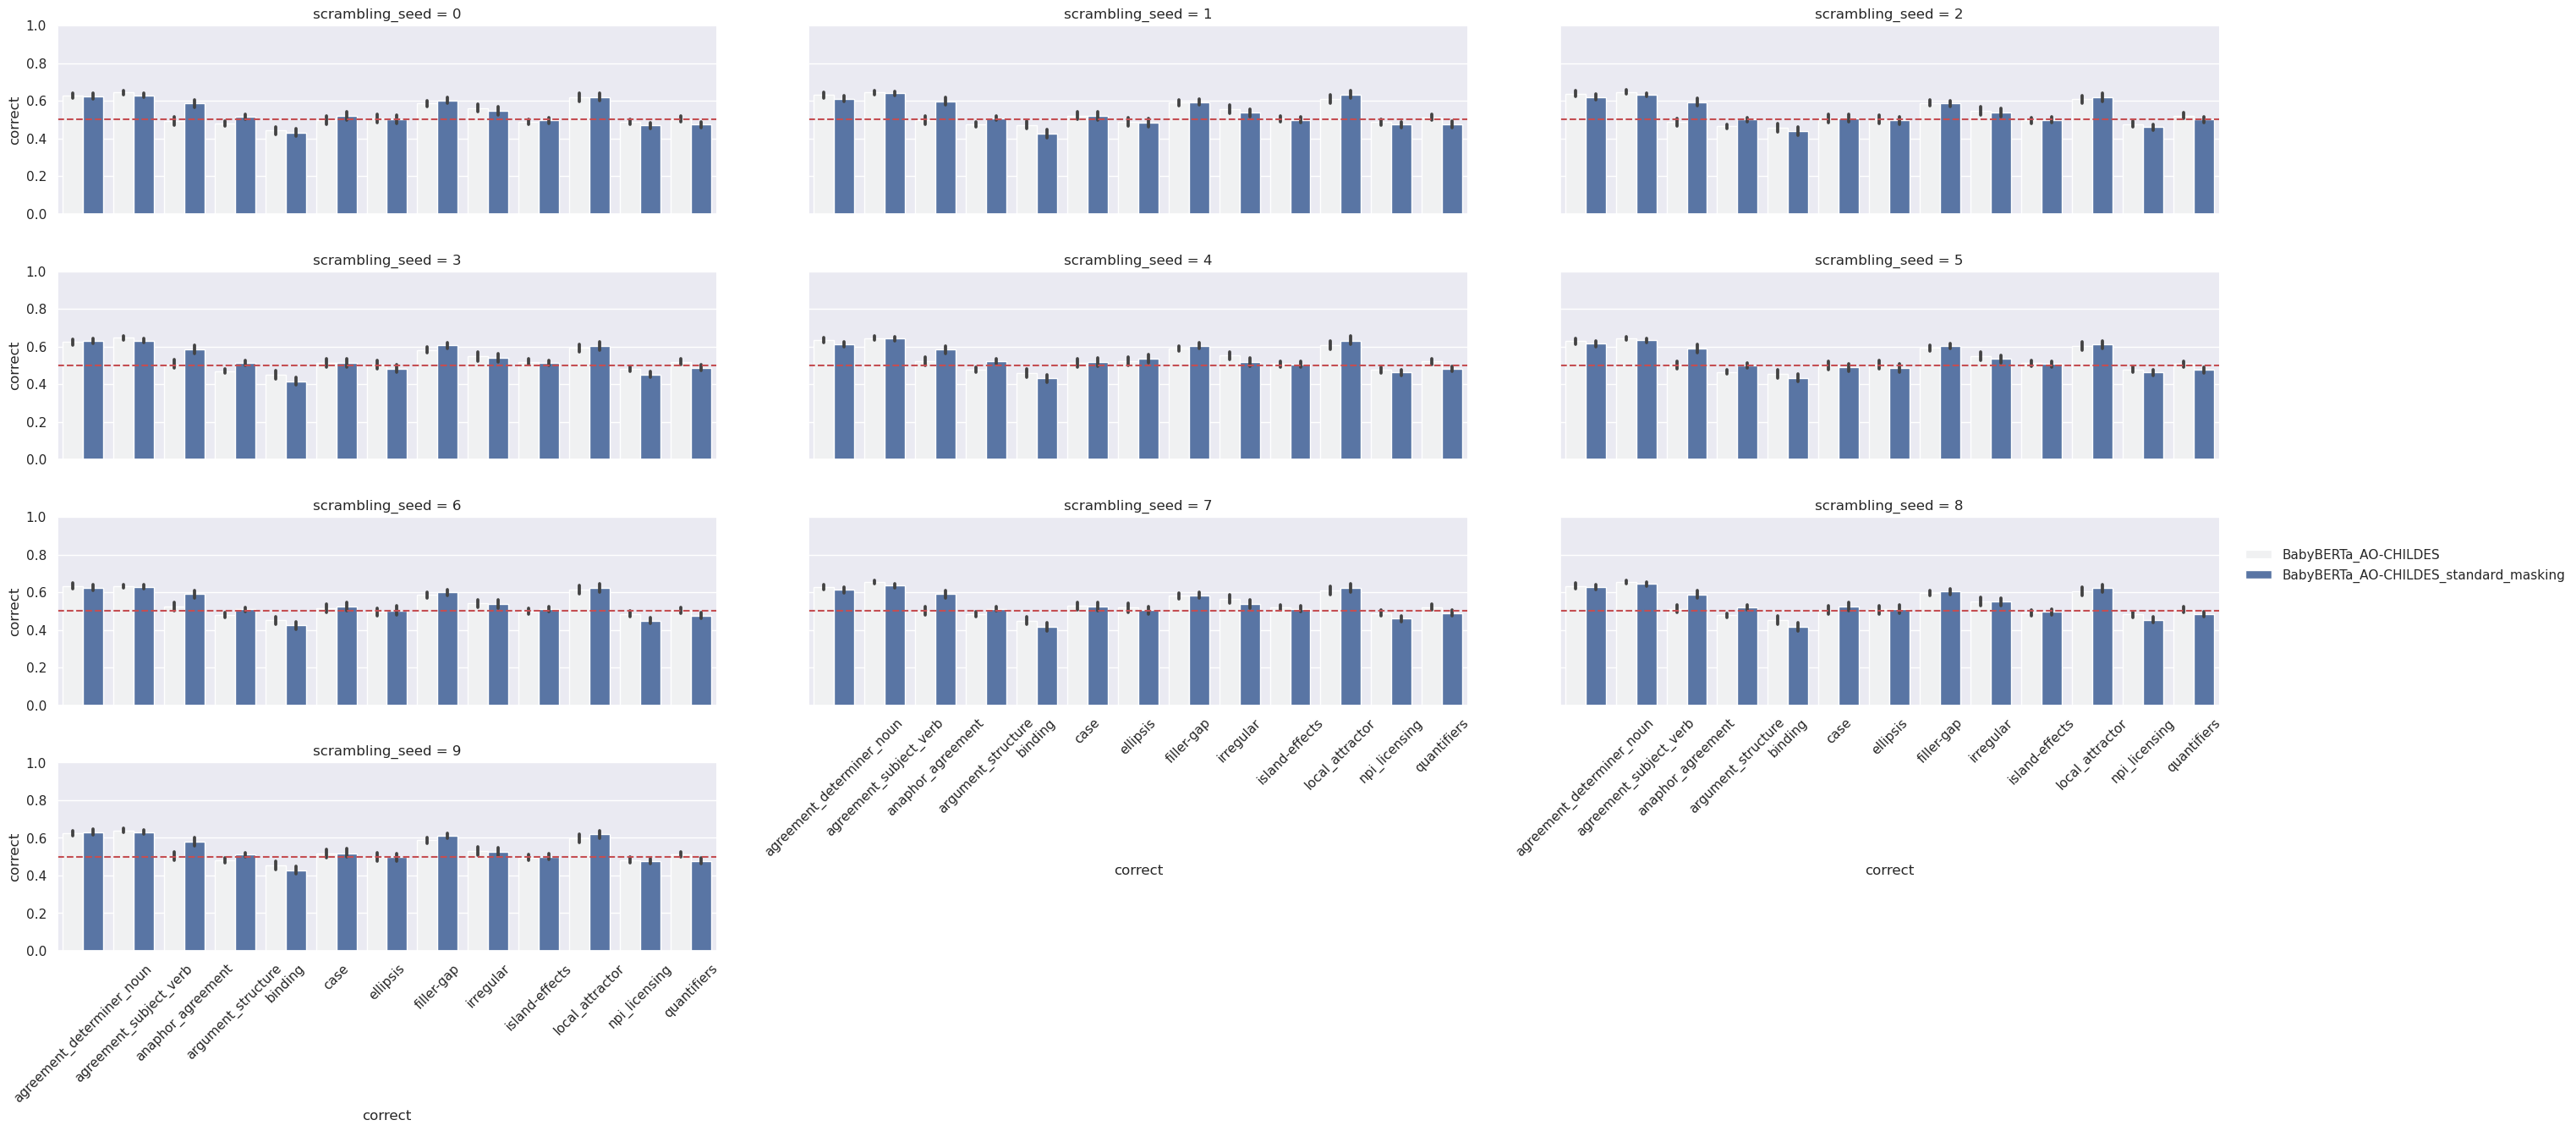

In [121]:
grid = sns.FacetGrid(scrambled_zorro_results, 
                  aspect=3, 
                  col="scrambling_seed", 
                  col_wrap=3,
                  palette="husl",
                  sharex=True,
                  sharey=True,
                  ylim=(0.0,1.0)
                 )
grid.map(sns.barplot, "phenomenon", "correct", "model")
grid.map(lambda y, **kw: plt.axhline(0.5, color="r", linestyle="--"), 'correct')

grid.set_xticklabels(rotation=45)
grid.add_legend()

plt.show()

In [122]:
## Get the results by paradigm.
new_cols = ["model", "phenomenon", "paradigm", "scrambling_seed", "correct"]
scrambled_zorro_paradigm_results = scrambled_zorro_results[new_cols]

# Apply DataFrame.groupby() averaging over the correct_col.
scrambled_zorro_paradigm_results = scrambled_zorro_paradigm_results.groupby(new_cols[:-1]).mean().reset_index()

display(scrambled_zorro_paradigm_results)

,model,phenomenon,paradigm,scrambling_seed,correct
0,BabyBERTa_AO-CHILDES,agreement_determiner_noun,across_1_adjective,0,0.6280
1,BabyBERTa_AO-CHILDES,agreement_determiner_noun,across_1_adjective,1,0.6290
2,BabyBERTa_AO-CHILDES,agreement_determiner_noun,across_1_adjective,2,0.6305
3,BabyBERTa_AO-CHILDES,agreement_determiner_noun,across_1_adjective,3,0.6245
4,BabyBERTa_AO-CHILDES,agreement_determiner_noun,across_1_adjective,4,0.6330
...,...,...,...,...,...
455,BabyBERTa_AO-CHILDES_standard_masking,quantifiers,superlative,5,0.4800
456,BabyBERTa_AO-CHILDES_standard_masking,quantifiers,superlative,6,0.4835
457,BabyBERTa_AO-CHILDES_standard_masking,quantifiers,superlative,7,0.4965
458,BabyBERTa_AO-CHILDES_standard_masking,quantifiers,superlative,8,0.4765


/home/hjvm/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


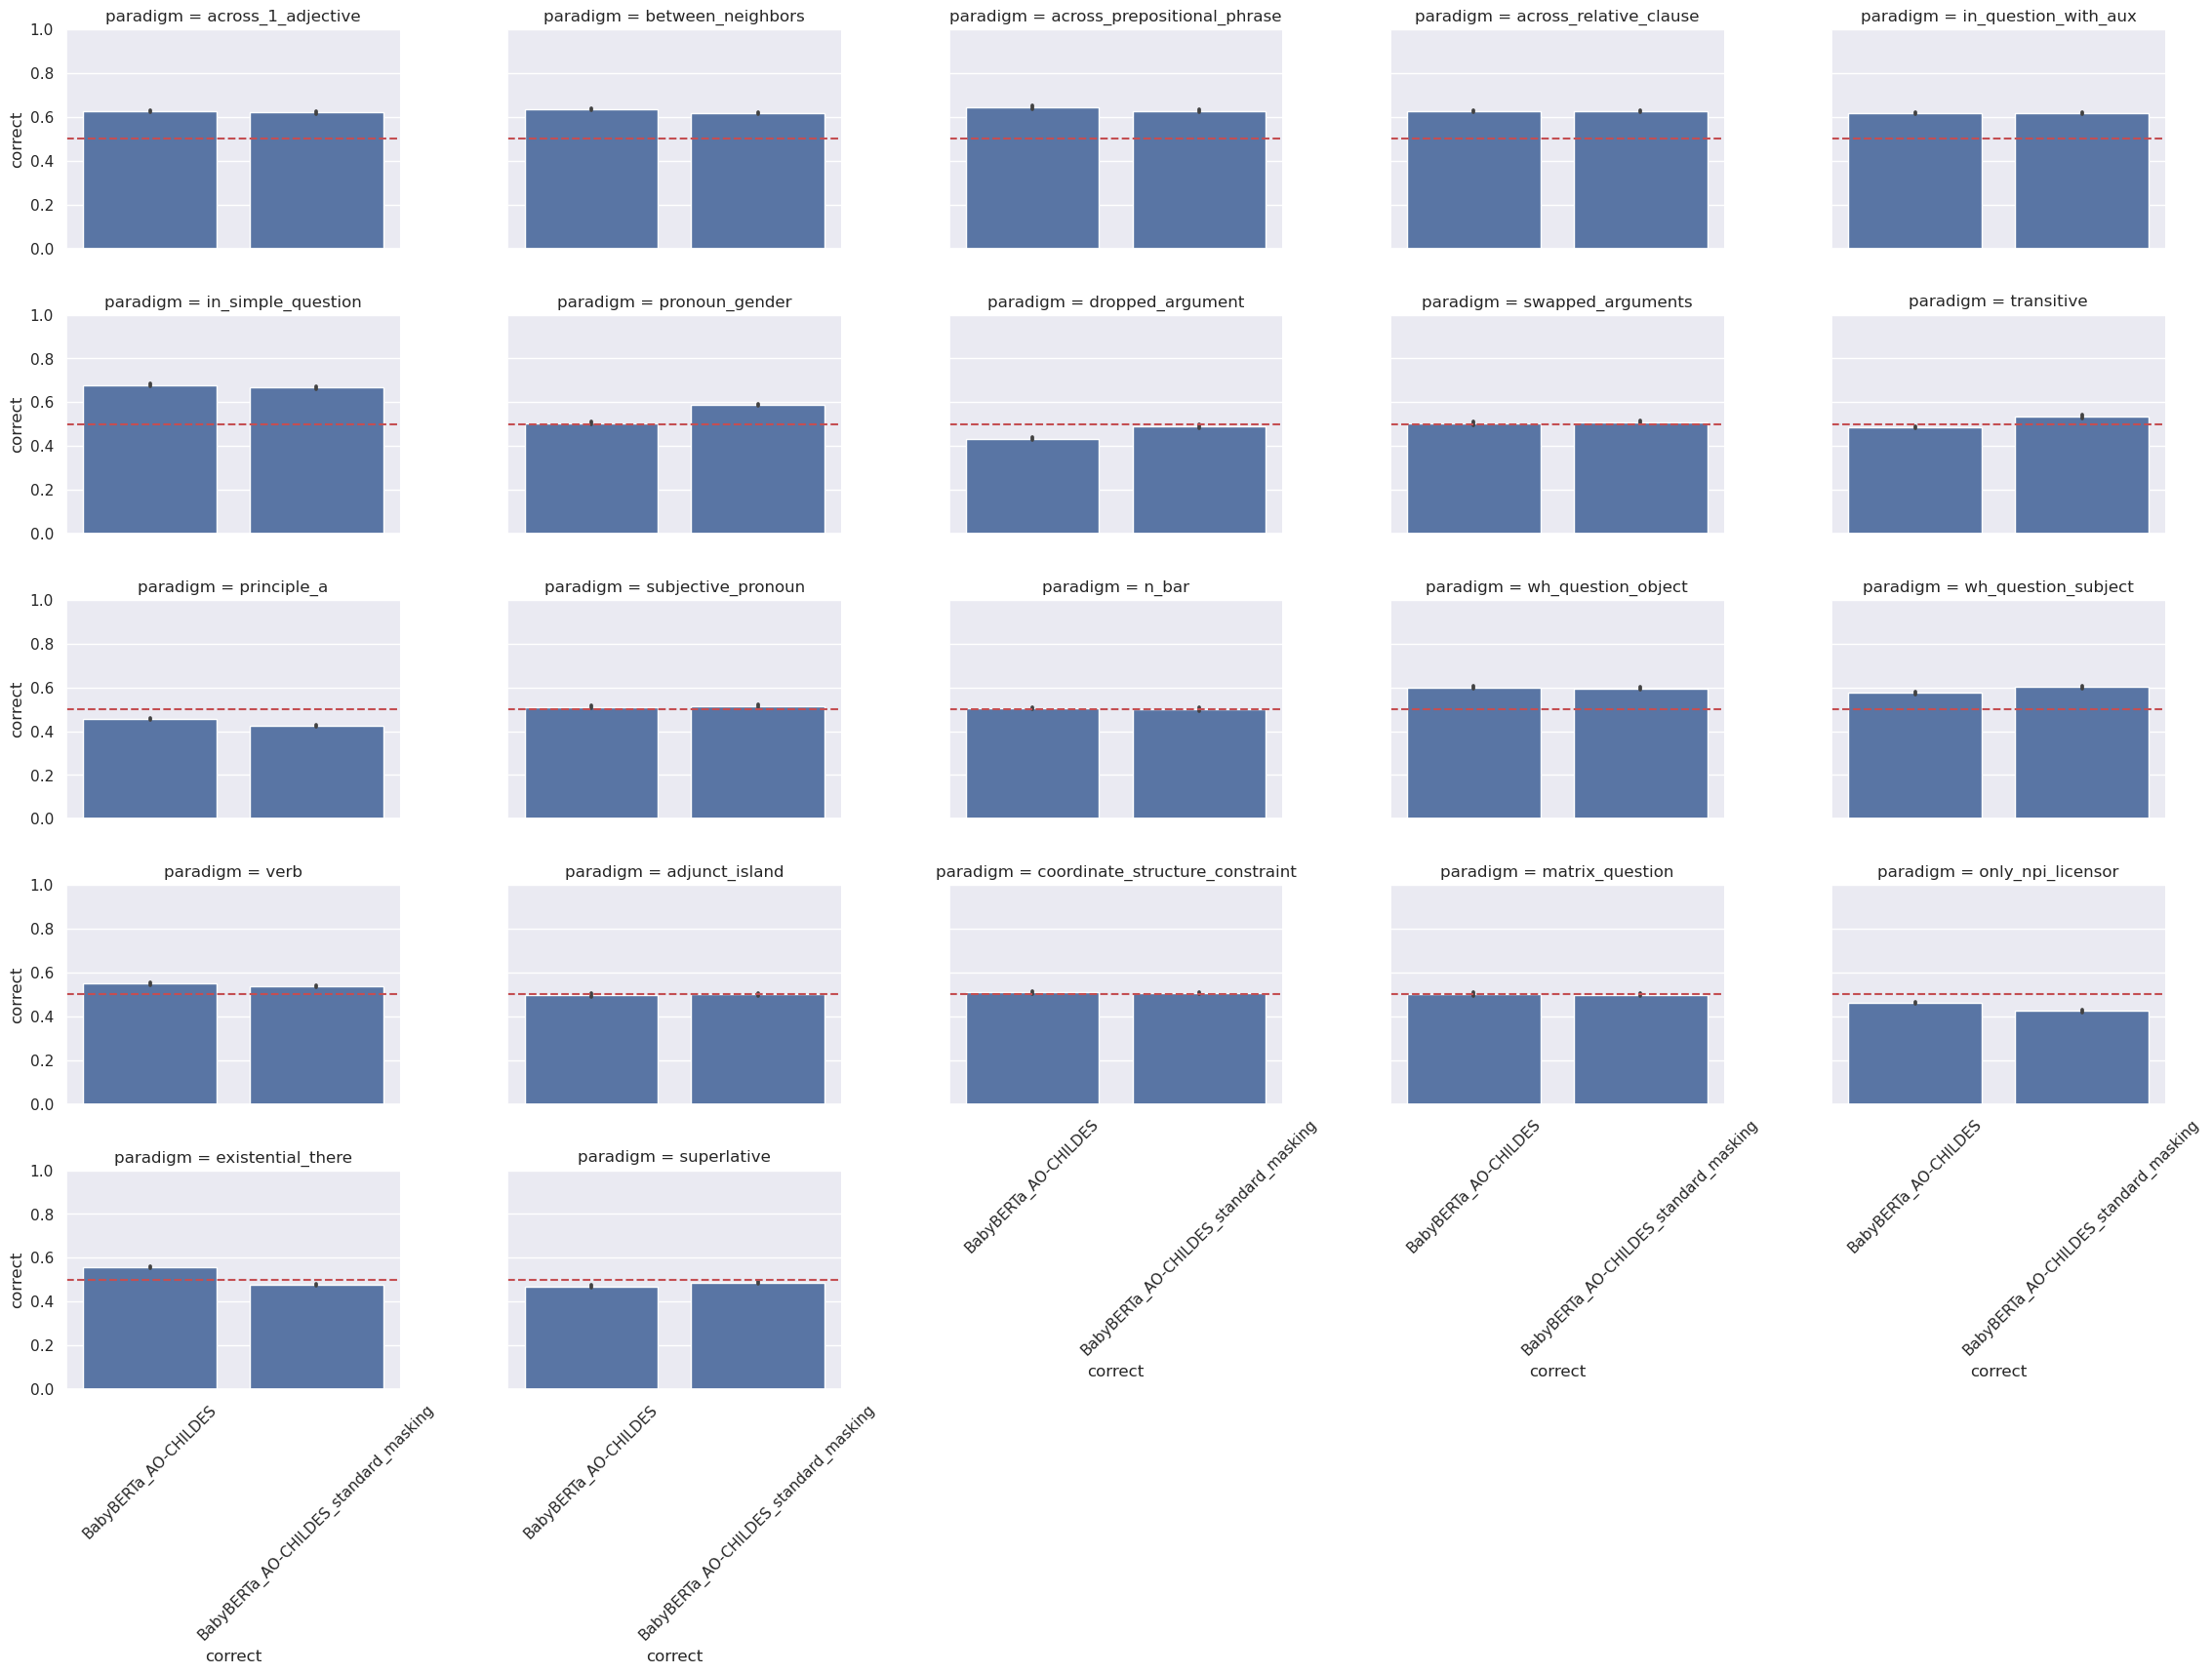

In [126]:
grid = sns.FacetGrid(scrambled_zorro_paradigm_results, 
                  aspect=1.5, 
                  col="paradigm", 
                  col_wrap=5,
                  palette="husl",
                  sharex=True,
                  sharey=True,
                  ylim=(0.0,1.0)
                 )
grid.map(sns.barplot, "model", "correct", errorbar="ci")
grid.map(lambda y, **kw: plt.axhline(0.5, color="r", linestyle="--"), 'correct')

grid.set_xticklabels(rotation=45)
grid.add_legend()

plt.show()